In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import pydicom

In [2]:
# set default plot style
plt.style.use('ggplot')

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
20323,00005433_000.png,Pleural_Thickening,0,5433,49,F,PA,2048,2500,0.171,0.171,NaN
79487,00019527_004.png,Pneumothorax,4,19527,68,M,PA,3056,2544,0.139,0.139,NaN
30277,00007894_002.png,Fibrosis|Infiltration,2,7894,71,M,PA,2500,2048,0.168,0.168,NaN


In [4]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
669,00003461_000.png,No Finding,0,3461,061Y,M,PA,2500,2048,0.171,0.171
745,00003899_002.png,No Finding,2,3899,012Y,M,PA,2960,2279,0.143,0.143
4896,00025812_004.png,Nodule,4,25812,049Y,M,PA,2714,2613,0.143,0.143


In [5]:
## EDA
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [6]:
# Extract finding labels for per disease distribution
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
29433,00007668_004.png,Effusion,4,7668,49,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6480,00001736_034.png,No Finding,34,1736,35,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
46860,00011955_004.png,No Finding,4,11955,54,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
# disease distribution
all_xray_df[all_labels].sum()/len(all_labels)

Atelectasis            770.600000
Cardiomegaly           185.066667
Consolidation          311.133333
Edema                  153.533333
Effusion               887.800000
Emphysema              167.733333
Fibrosis               112.400000
Hernia                  15.133333
Infiltration          1326.266667
Mass                   385.466667
No Finding            4024.066667
Nodule                 422.066667
Pleural_Thickening     225.666667
Pneumonia               95.400000
Pneumothorax           353.466667
dtype: float64

[Text(0, 0.5, 'Number of images with label')]

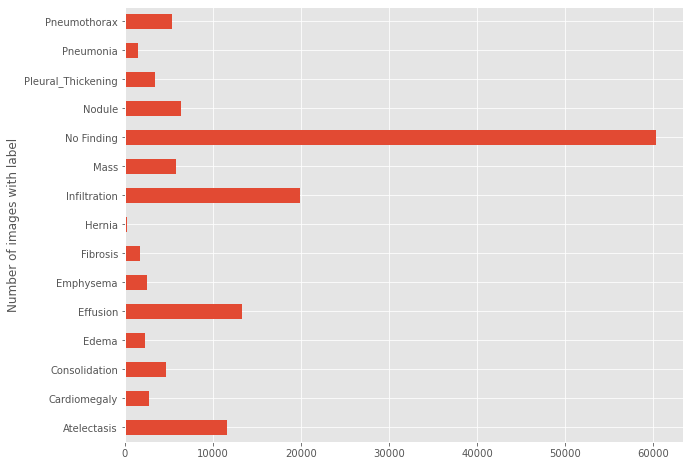

In [8]:
# histogram distribution
plt.figure(figsize=(10, 8))
ax = all_xray_df[all_labels].sum().plot(kind='barh')
ax.set(ylabel = 'Number of images with label')

Above plot reveals no finding to be the main label, but when there is any label available, Infiltration, Effussion and Atelectasis are the primary occurance!

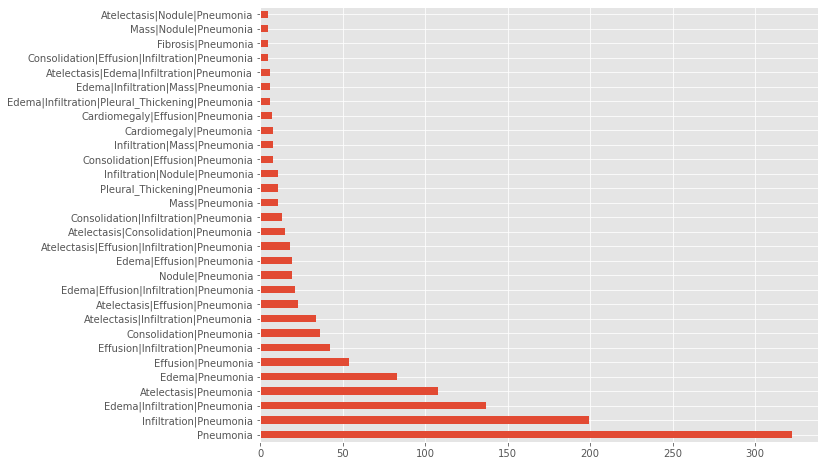

In [9]:
# check for Pneumonia
plt.figure(figsize=(10, 8))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='barh')

In [10]:
# Prevalence of pneumonia
all_xray_df['Pneumonia'].sum()/len(all_xray_df)

0.012763110952550838

In [11]:
# Pneumonia patient count
print('Number of patients with Pneumonia: ', all_xray_df['Pneumonia'].sum())

Number of patients with Pneumonia:  1431.0


(array([4.1465e+04, 7.0265e+04, 3.7400e+02, 1.0000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([  1. ,  42.3,  83.6, 124.9, 166.2, 207.5, 248.8, 290.1, 331.4,
        372.7, 414. ]),
 <a list of 10 Patch objects>)

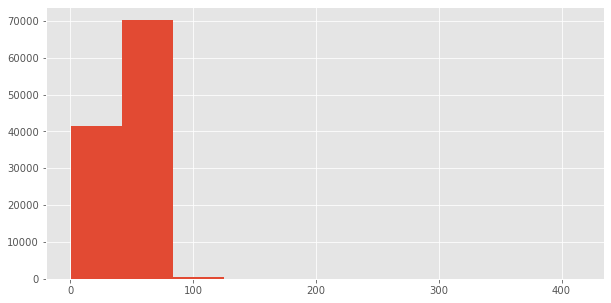

In [12]:
# Patient demographics
plt.figure(figsize=(10, 5))
plt.hist(all_xray_df['Patient Age'])

Looks like there are some age values which is more than 100, and is as high as 400+

In [13]:
error_age = all_xray_df[all_xray_df['Patient Age'] > 100]['Patient Age'].sort_values()
error_age

48284     148
55742     148
62929     149
58650     150
78795     151
74884     152
95794     153
98495     154
101194    155
104590    155
84810     411
20852     412
85404     412
91369     412
86264     413
46965     414
Name: Patient Age, dtype: int64

All this data seems like a error in the record as there can't be a person with age 148 or 414 years.

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

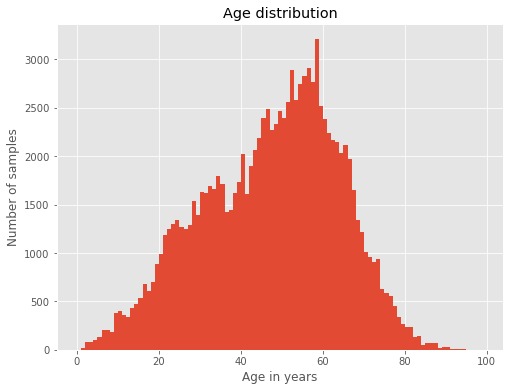

In [14]:
# corrected age distirbution
plt.figure(figsize=(8, 6))
all_xray_df['Patient Age'].hist(bins=np.arange(0,100))
plt.title('Age distribution')
plt.ylabel('Number of samples')
plt.xlabel('Age in years')

all_xray_df['Patient Age'].describe()

Text(0.5, 0, 'Age in years')

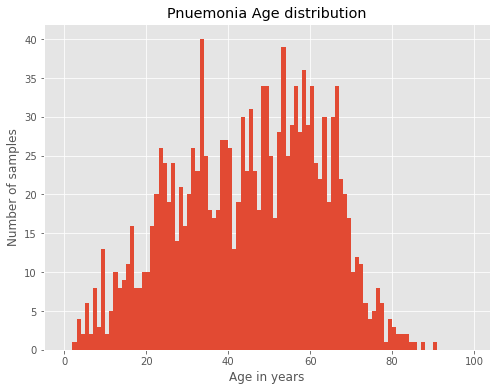

In [15]:
# age distribution for pneumonia only
plt.figure(figsize=(8, 6))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'].hist(bins=np.arange(0,100))
plt.title('Pnuemonia Age distribution')
plt.ylabel('Number of samples')
plt.xlabel('Age in years')

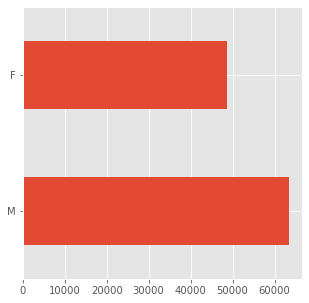

In [16]:
plt.figure(figsize=(5, 5))
all_xray_df['Patient Gender'].value_counts().plot(kind='barh')

In [17]:
# grouby age
all_xray_df.groupby(['Patient Gender']).size()

Patient Gender
F    48780
M    63340
dtype: int64

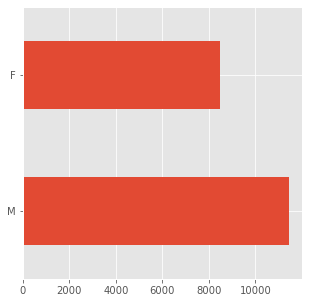

In [18]:
plt.figure(figsize=(5, 5))
all_xray_df[all_xray_df.Infiltration ==1]['Patient Gender'].value_counts().plot(kind='barh')

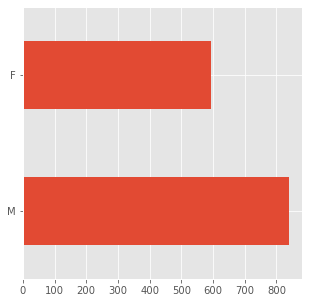

In [19]:
plt.figure(figsize=(5, 5))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='barh')

count     1431
unique       2
top          M
freq       838
Name: Patient Gender, dtype: object

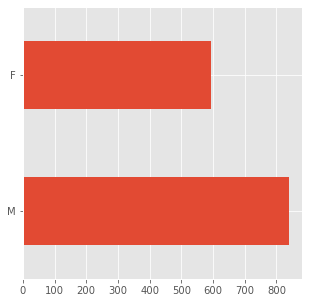

In [20]:
plt.figure(figsize=(5, 5))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='barh')
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].describe()

In [21]:
# groupby view position
all_xray_df.groupby(['View Position']).size()

View Position
AP    44810
PA    67310
dtype: int64

Dataset is highly unbalanced in terms of demographics distribution, and same for the diesease based distribution. So some preprocessing is needed to balance the dataset.

### X-ray image data and pixel level intensity

In [22]:
# Extract finding labels for per disease distribution for sample dataset
sample_all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
sample_all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2479,00012470_016.png,No Finding,16,12470,015Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
772,00004066_005.png,Effusion,5,4066,031Y,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995,00005215_000.png,No Finding,0,5215,040Y,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


/data/images_009/images/00019021_001.png : Pneumonia
/data/images_010/images/00022192_032.png : Pneumonia
/data/images_008/images/00017714_019.png : Pneumonia


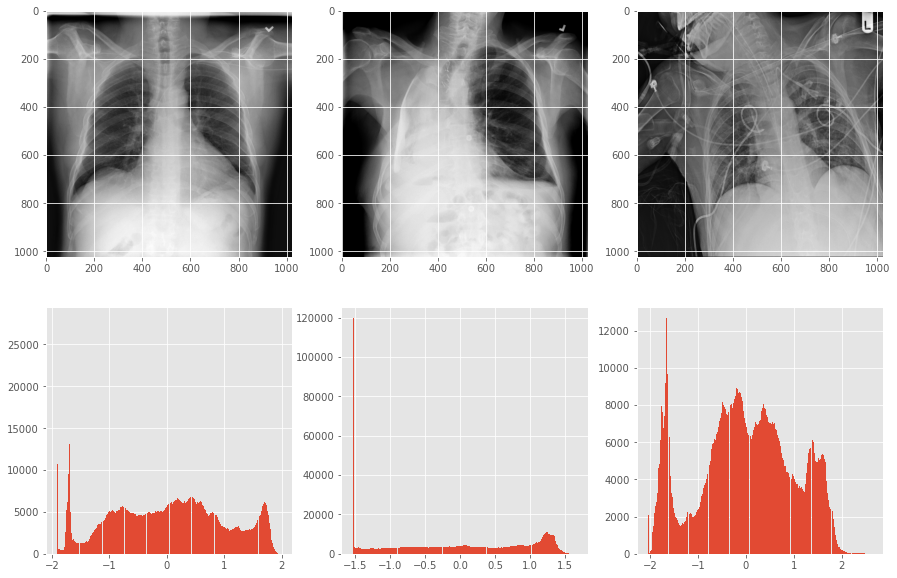

In [49]:
# Only pneumonia
image = []
for idx, img in sample_df[sample_df['Finding Labels']=='Pneumonia'].sample(3).iterrows():
    file_name = img['Image Index']
    print('{} : {}'.format(all_image_paths.get(file_name), sample_df['Finding Labels'][idx]))
    image.append(plt.imread(all_image_paths.get(file_name)))
    
f, axarr = plt.subplots(2, 3, figsize=(15, 10))
    
for i in range(len(image)):
    axarr[0,i].imshow(image[i], cmap='gray')
    mean_intensity = np.mean(image[i])
    std_intensity = np.std(image[i])
    new_image = np.copy(image[i])
    image[i] = (new_image - mean_intensity)/std_intensity
    axarr[1,i].hist(image[i].ravel(), bins=256)

From above, we can say that intensity distribution is different for different x-ray images with only pneumonia. So we need to normalize the distribution to get a better idea. 

Doing so results in not much useful information, but we can see that most of the pixel level distribution is around one standard deviation. There are random spike some have it within one standard deviation whereas others have it around first standard deviation. More or less the distribution is not consistent across all the images of this class and so a simple threshold setting algortihm won't be useful, and we need to rely more on feature level matching using deep neural network to get better performance.

We also see a spike at the start of the distribution which occurs due to presence of background and had to be removed. So we need to preprocess images before feeding them to a deep neural network model.

/data/images_010/images/00023057_000.png : Infiltration
/data/images_005/images/00010092_042.png : Infiltration
/data/images_006/images/00013197_001.png : Infiltration


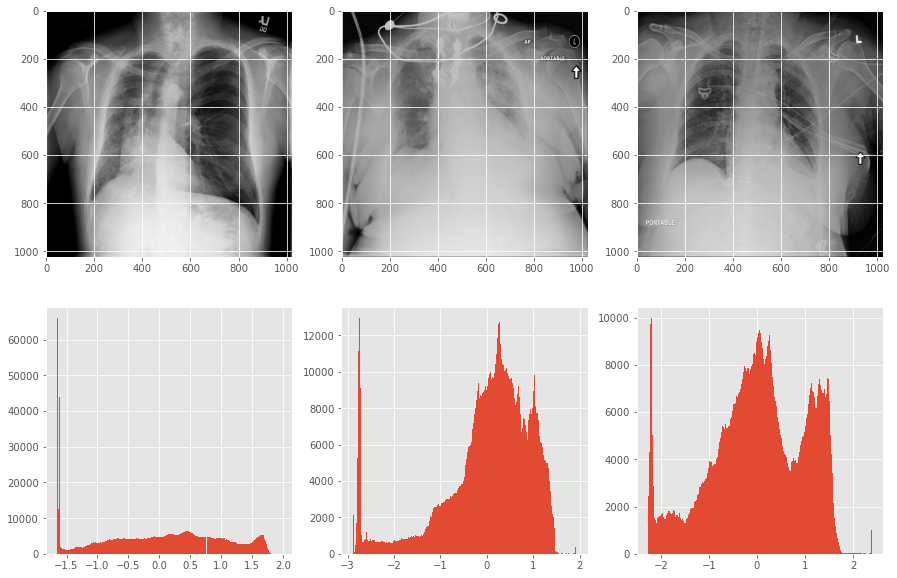

In [43]:
# Only Infiltration
image = []
for idx, img in sample_df[sample_df['Finding Labels']=='Infiltration'].sample(3).iterrows():
    file_name = img['Image Index']
    print('{} : {}'.format(all_image_paths.get(file_name), sample_df['Finding Labels'][idx]))
    image.append(plt.imread(all_image_paths.get(file_name)))
    
f, axarr = plt.subplots(2, 3, figsize=(15, 10))
    
for i in range(len(image)):  
    axarr[0,i].imshow(image[i],cmap='gray')
    mean_intensity = np.mean(image[i])
    std_intensity = np.std(image[i])
    image[i] = (image[i] - mean_intensity)/std_intensity
    axarr[1,i].hist(image[i].ravel(), bins=256)

/data/images_003/images/00006160_001.png : Edema
/data/images_009/images/00018867_016.png : Edema
/data/images_007/images/00015264_003.png : Edema


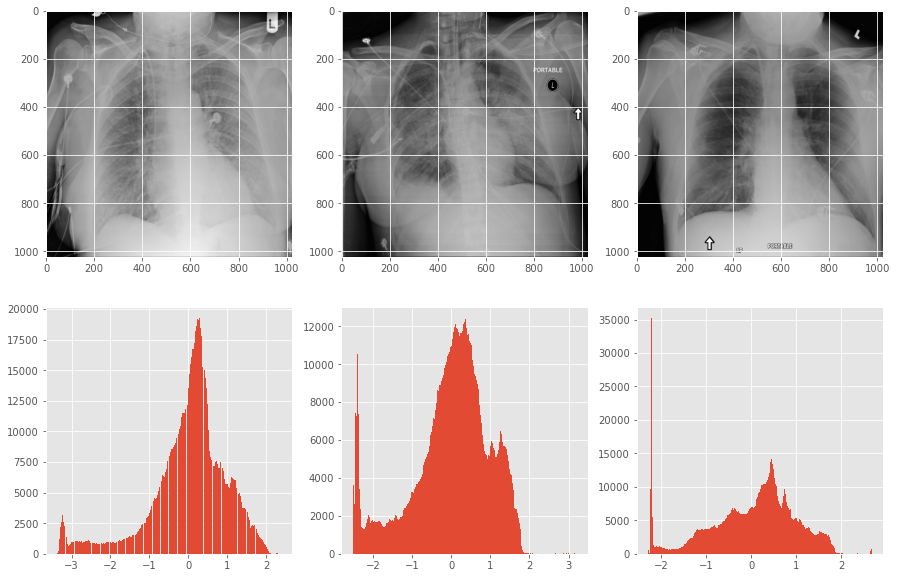

In [45]:
# Edema lungs
image = []
for idx, img in sample_df[sample_df['Finding Labels']=='Edema'].sample(3).iterrows():
    file_name = img['Image Index']
    print('{} : {}'.format(all_image_paths.get(file_name), sample_df['Finding Labels'][idx]))
    image.append(plt.imread(all_image_paths.get(file_name)))
    
f, axarr = plt.subplots(2, 3, figsize=(15, 10))
    
for i in range(len(image)):  
    axarr[0,i].imshow(image[i],cmap='gray')
    mean_intensity = np.mean(image[i])
    std_intensity = np.std(image[i])
    image[i] = (image[i] - mean_intensity)/std_intensity
    axarr[1,i].hist(image[i].ravel(), bins=256)

/data/images_003/images/00006514_000.png : Atelectasis
/data/images_004/images/00007340_000.png : Atelectasis
/data/images_012/images/00030247_010.png : Atelectasis


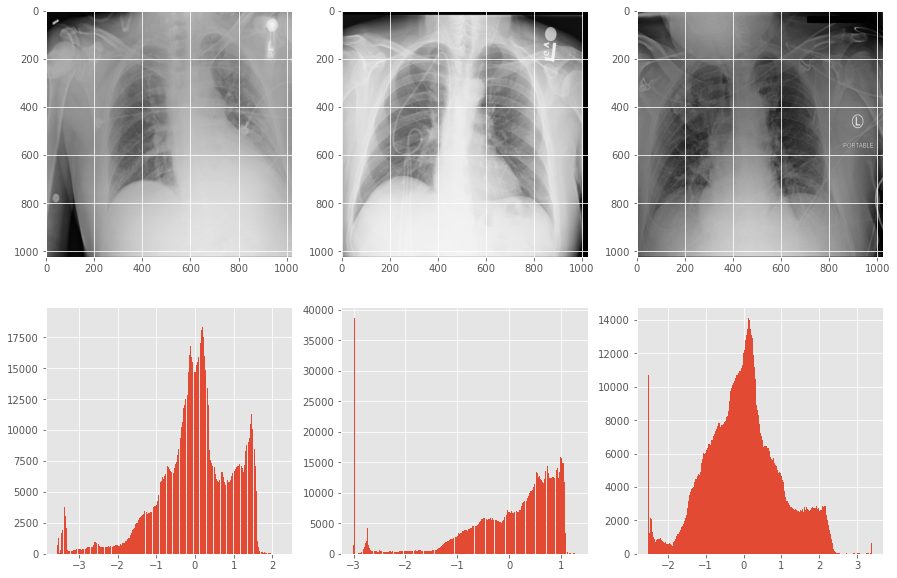

In [47]:
# Atelectasis lungs
image = []
for idx, img in sample_df[sample_df['Finding Labels']=='Atelectasis'].sample(3).iterrows():
    file_name = img['Image Index']
    print('{} : {}'.format(all_image_paths.get(file_name), sample_df['Finding Labels'][idx]))
    image.append(plt.imread(all_image_paths.get(file_name)))
    
f, axarr = plt.subplots(2, 3, figsize=(15, 10))
    
for i in range(len(image)):  
    axarr[0,i].imshow(image[i],cmap='gray')
    mean_intensity = np.mean(image[i])
    std_intensity = np.std(image[i])
    image[i] = (image[i] - mean_intensity)/std_intensity
    axarr[1,i].hist(image[i].ravel(), bins=256)

Now, taking a look at three most common co-morbid diseases along with pnumonia in our dataset, we observe that that distribution is inconsisent within the same class of images. 

Inflitration is the most common comorbid with pnuemonia, which we saw from our patient wise disease distribution earlier. Here we see some nice pattern in the spike occurance within the single standard deviation around mean. One important thing we observe here is the image distribution is a bit different than the only pneumonia images, and here we have more intensity spikes. 

Talking about Edema, is more or less centered around the mean, but is more inclined on the negative first standard deviation. Also it has less numbe of intensity spikes compared to Infiltration and pneumonia.

Whereas, in case of Atelectasis, the distribution is unevenly centered within images. It can have spikes on positive or negative both sides of mean and can be spread across two standard deviations. 

/data/images_002/images/00001677_000.png : No Finding
/data/images_001/images/00000835_000.png : No Finding
/data/images_010/images/00024383_000.png : No Finding


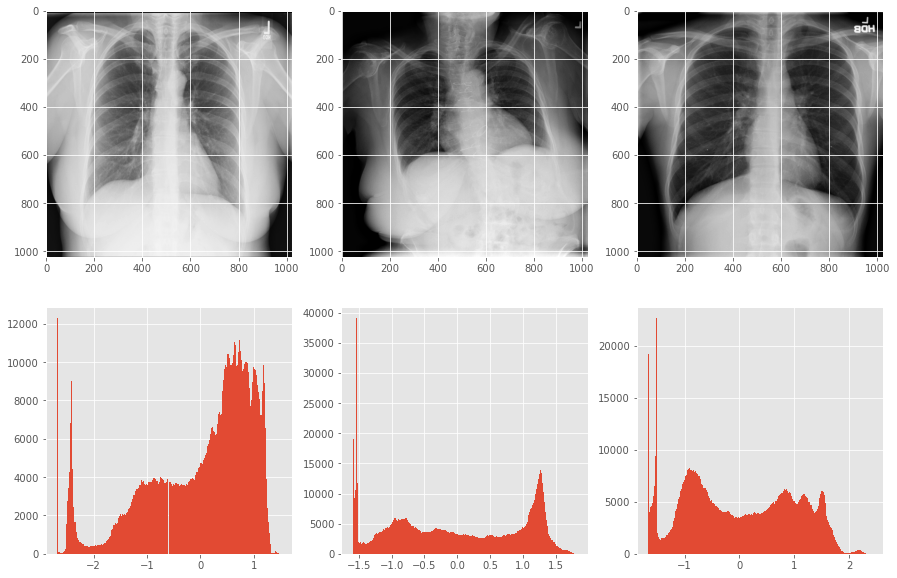

In [48]:
# healthy lungs, no findings
image = []
for idx, img in sample_df[sample_df['No Finding']==1].sample(3).iterrows():
    file_name = img['Image Index']
    print('{} : {}'.format(all_image_paths.get(file_name), sample_df['Finding Labels'][idx]))
    image.append(plt.imread(all_image_paths.get(file_name)))
    
f, axarr = plt.subplots(2, 3, figsize=(15, 10))
    
for i in range(len(image)):  
    axarr[0,i].imshow(image[i],cmap='gray')
    mean_intensity = np.mean(image[i])
    std_intensity = np.std(image[i])
    image[i] = (image[i] - mean_intensity)/std_intensity
    axarr[1,i].hist(image[i].ravel(), bins=256)

Above is the representation of the healthy lungs with no findings of any thoraic diseases. On inspeecting the intensity distribution, we observe most of the pixels are distributed around the mean, and is present in single standard deviation, but concentrated on the positive side. Though it has few exception, so we can conclude that a healthy lung will have less intensity spikes outside single standard deviation distribution. The shape of distribution for this type is mostly even but distribution is similar to that with dieseases with less abnormalities.

That said, it is a diffcult to identify the presence of any thoraic diseases by just looking at the intensity distribution. So we need to implement an intelligent algorithm which can look at all the minor features from our dataset and give us a good accurate prediction.